# Image Classification Using CNN
- [Introduction](#intro)
- [Part 1: Data Preprocessing](#part1)
- [Part 2: CNN Building](#part2)
- [Part 3: CNN Training](#part3)
- [Part 4: CNN Testing](#part4)

<a id='intro'></a>
## Introduction

In this project, I'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) using CNNs built with tensorflow's nn library.  The CIFAR-10 dataset consists of airplanes, dogs, cats, and other animals and objects (10 classes in total). 

The notebook consists of 4 parts: in Part 1 I'll preprocess the data. In Part 2, I'll build the network, which will then be trained and tested in Parts 2 and 3, respectively. An accuracy of ~67% is achieved. 

<a id='part1'></a>
## Part 1: Data Preprocessing

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import random

We first download the CIFAR-10 dataset:

In [2]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

# setting the progress bar
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

# downloading dataset
if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

# extracting files
if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()

CIFAR-10 Dataset: 171MB [03:11, 892KB/s]                               


We can have a look at one sample image and associated stats:


Example of Image 245:
Image - Min Value: 0 Max Value: 188
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


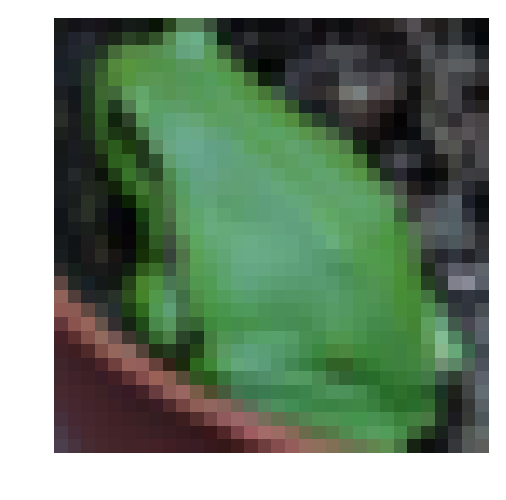

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# display one example and associated stats
batch_id = 1
sample_id = 245

# Load features and labels for a particular batch
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
sample_image = features[sample_id]
sample_label = labels[sample_id]
print('\nExample of Image {}:'.format(sample_id))
print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
print('Image - Shape: {}'.format(sample_image.shape))
print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
plt.axis('off')
plt.imshow(sample_image)

We then perform the preprocessing of the training, validation and testing data and save the obtained files. Preprocessing steps consist in normalization and one-hot-encoding of the data. 10% of each training batch is used as validation.

In [4]:
batch_ids = list(range(1, 6))

# Normalize data
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.
    : return: Numpy array of normalize data
    """
    return x/255

# One-hot-encoding 
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    tmp = np.zeros((len(x), 10))
    for idx_label in range(len(x)):
        tmp[idx_label][x[idx_label]] = 1
    return tmp

# Apply normalization and one-hot-encoding and save to file
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess features and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))

# Preprocess and save training and validation data for each batch as well as testing data
def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess training and validation data for each batch as well as testing data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    # load data for each batch
    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Preprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the test data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and save all test data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')

preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

<a id='part2'></a>
## Part 2: CNN Building

The CNN that I build here will combine 2 convolution + maxpool layers followed by a fully connected layer with some dropout and an output layer.

First, let's build our layers using the tf.nn library.

In [5]:
# Implement the base class for convolution + maxpool layers
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weight = tf.Variable(tf.truncated_normal([conv_ksize[0], conv_ksize[1], int(x_tensor.shape[3]), conv_num_outputs], stddev=0.1))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    strides = [1, conv_strides[0], conv_strides[1], 1]
    padding = 'SAME'
    
    x_tensor = tf.nn.conv2d(x_tensor, weight, strides, padding)
    x_tensor = tf.nn.bias_add(x_tensor, bias)
    x_tensor = tf.nn.relu(x_tensor)
    x_tensor = tf.nn.max_pool(x_tensor, [1, pool_ksize[0], pool_ksize[1], 1], [1, pool_strides[0], pool_strides[1], 1], padding)
    return x_tensor

# Implement the base class for fully connected layers:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weight = tf.Variable(tf.truncated_normal([int(x_tensor.get_shape()[1]), num_outputs], stddev=0.1))
    bias = tf.Variable(tf.zeros([num_outputs]))
    x_tensor = tf.add(tf.matmul(x_tensor, weight), bias)
    x_tensor = tf.nn.relu(x_tensor)
    return x_tensor

# Implement the base class for the output layer:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weight = tf.Variable(tf.truncated_normal([int(x_tensor.get_shape()[1]), num_outputs], stddev=0.1))
    bias = tf.Variable(tf.zeros([num_outputs]))
    x_tensor = tf.add(tf.matmul(x_tensor, weight), bias)
    return x_tensor

We can then combine the layers to implement the architecture of the neural network:

In [6]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    # Apply two convolution and maxpool layers
    conv_num_outputs = 32
    conv_ksize = (2, 2)
    conv_strides = (1, 1) 
    pool_ksize = (2, 2)
    pool_strides = (1, 1)
    x_tensor = conv2d_maxpool(x, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    conv_num_outputs = 64
    conv_ksize = (2, 2)
    conv_strides = (1, 1) 
    pool_ksize = (2, 2)
    pool_strides = (1, 1)
    x_tensor = conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    # Flatten the image from a 4-D tensor to a 2-D tensor (Batch Size, Flattened Image Size)
    x_tensor = tf.reshape(x_tensor, [tf.shape(x_tensor)[0], x_tensor.get_shape().as_list()[1]*x_tensor.get_shape().as_list()[2]*x_tensor.get_shape().as_list()[3]])
    
    # Apply fully connected layer and dropout
    x_tensor = fully_conn(x_tensor, 512)
    x_tensor = tf.nn.dropout(x_tensor, keep_prob)

    # Return output
    x_tensor = output(x_tensor, 10)
    
    return x_tensor

Finally, let's build the network:

In [7]:
# Remove previous weights, bias, inputs, etc.
tf.reset_default_graph()

# Define inputs as placeholders
image_shape = (32, 32, 3)
x = tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]], name='x')

n_classes = 10
y = tf.placeholder(tf.float32, [None, n_classes], name='y')

keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Define logits
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

<a id='part3'></a>
## Part 3: CNN Training

We can now train the CNN. The obtained model will be saved under the 'save_model_path'.

In [8]:
# setting hyperparameters
epochs = 7
batch_size = 128
keep_probability = 0.5

# Split features and labels of testing data into smaller batches of size batch_size. 
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]
        
# Load preprocessed training data
def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the preprocessed training data
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    return batch_features_labels(features, labels, batch_size)

# Load preprocessed validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                sess.run(optimizer, feed_dict={
                    x: batch_features,
                    y: batch_labels,
                    keep_prob: keep_probability})
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            
            # print stats
            loss = sess.run(cost, feed_dict={
                x: batch_features,
                y: batch_labels,
                keep_prob: 1.})
            print('loss: ', loss)
            valid_acc = sess.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1.})
            print('accuracy: ', valid_acc)
            
    # saving model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)
    print('Model saved')

Training...
Epoch  1, CIFAR-10 Batch 1:  loss:  1.802
accuracy:  0.378
Epoch  1, CIFAR-10 Batch 2:  loss:  1.36287
accuracy:  0.4594
Epoch  1, CIFAR-10 Batch 3:  loss:  1.23318
accuracy:  0.5126
Epoch  1, CIFAR-10 Batch 4:  loss:  1.25223
accuracy:  0.5302
Epoch  1, CIFAR-10 Batch 5:  loss:  1.32855
accuracy:  0.565
Epoch  2, CIFAR-10 Batch 1:  loss:  1.26605
accuracy:  0.5732
Epoch  2, CIFAR-10 Batch 2:  loss:  0.951352
accuracy:  0.588
Epoch  2, CIFAR-10 Batch 3:  loss:  0.866742
accuracy:  0.5818
Epoch  2, CIFAR-10 Batch 4:  loss:  0.988889
accuracy:  0.6128
Epoch  2, CIFAR-10 Batch 5:  loss:  1.02764
accuracy:  0.6146
Epoch  3, CIFAR-10 Batch 1:  loss:  0.945166
accuracy:  0.618
Epoch  3, CIFAR-10 Batch 2:  loss:  0.726485
accuracy:  0.6252
Epoch  3, CIFAR-10 Batch 3:  loss:  0.63582
accuracy:  0.6356
Epoch  3, CIFAR-10 Batch 4:  loss:  0.733161
accuracy:  0.628
Epoch  3, CIFAR-10 Batch 5:  loss:  0.762566
accuracy:  0.6372
Epoch  4, CIFAR-10 Batch 1:  loss:  0.747843
accuracy:  0.

<a id='part4'></a>
## Part 4: CNN Testing

Finally, let's load the model and test it. I also show the top predictions for a few randomly selected samples.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6706882911392406




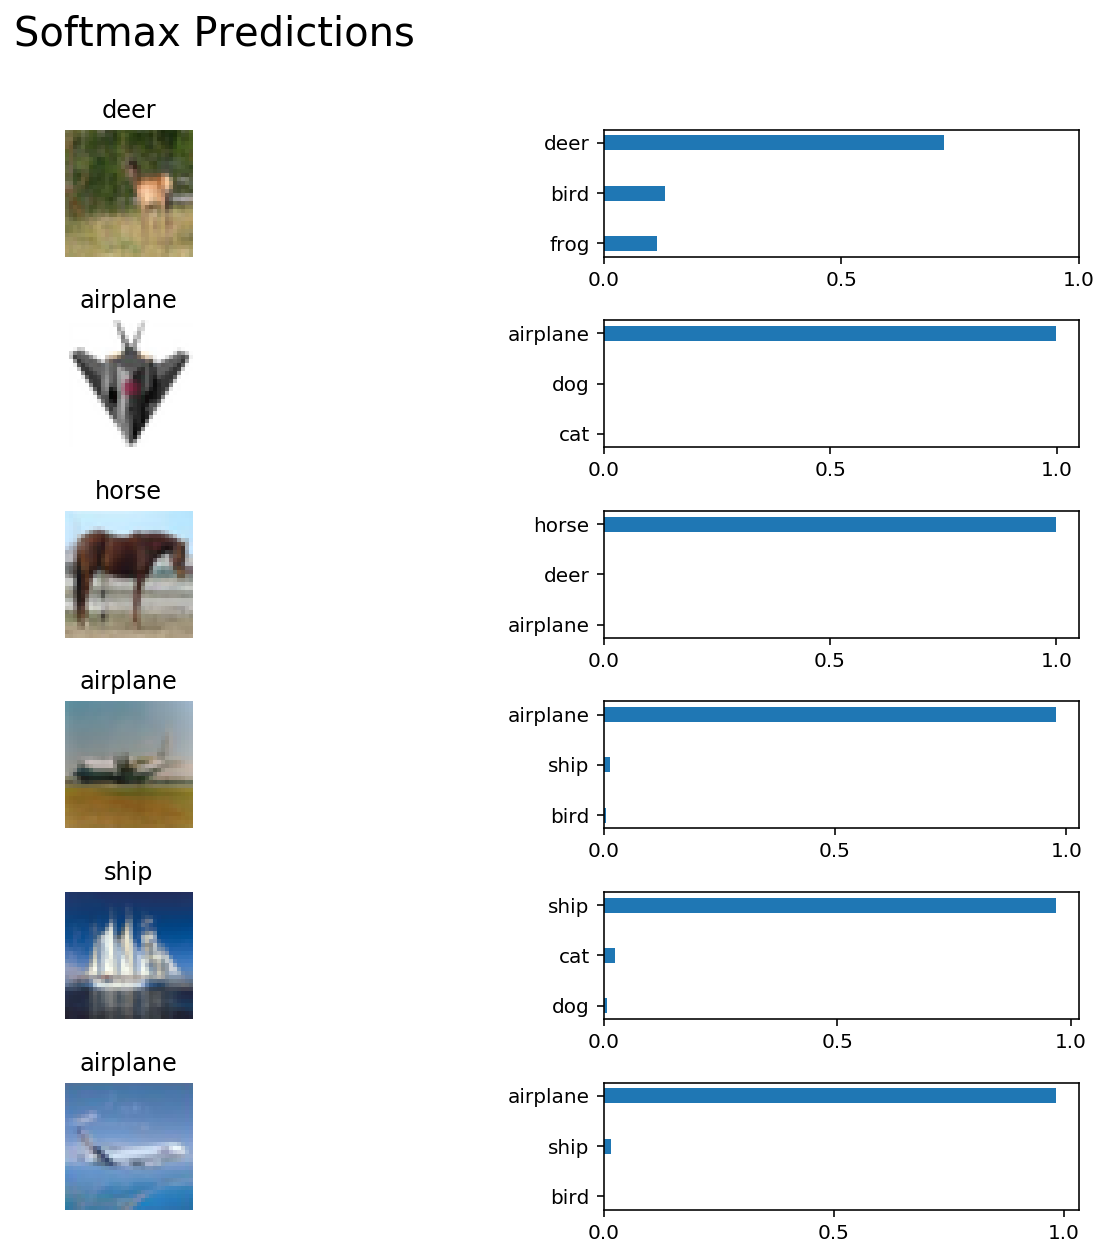

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Display n_samples and the corresponding top_n_predictions most probable classes as predicted by the model         
def display_image_predictions(features, labels, predictions, n_samples, top_n_predictions):
    n_classes = 10
    label_names = label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=n_samples, ncols=2)
    fig.subplots_adjust(top = 2, right = 1.5, wspace = 0.5, hspace = 0.5)
    fig.suptitle('Softmax Predictions', fontsize=20, y=2.2)

    n_predictions = top_n_predictions
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

def test_model():
    """
    Test the saved model against the test dataset
    """
    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print the top predictions for a few random samples
        n_samples = 6
        top_n_predictions = 3
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        print()
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions, n_samples, top_n_predictions)

test_model()